## 필요한 라이브러리 install

In [ ]:
!pip install torch torchvision torchaudio tensorflow albumentations timm opencv-python matplotlib kagglehub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 51.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlink

## 드라이브 마운트

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 데이터셋 합치기 + 불러오기

In [ ]:
# 캐글 데이터셋 다운로드 라이브러리
import kagglehub

In [ ]:
## face_data

# Download latest version
path1 = kagglehub.dataset_download("xhlulu/140k-real-and-fake-faces")

print("Path to dataset files:", path1)

100%|██████████| 3.75G/3.75G [01:02<00:00, 64.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/xhlulu/140k-real-and-fake-faces/versions/2


In [ ]:
#CIFAKE Midjourney 변형 데이터셋

# Download latest version
path2 = kagglehub.dataset_download("mariammarioma/midjourney-cifake-inspired")

print("Path to dataset files:", path2)

100%|██████████| 2.78G/2.78G [00:51<00:00, 58.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/mariammarioma/midjourney-cifake-inspired/versions/1


In [ ]:
#CIFAKE 데이터셋

# Download latest version
path3 = kagglehub.dataset_download("birdy654/cifake-real-and-ai-generated-synthetic-images")

print("Path to dataset files:", path3)

100%|██████████| 105M/105M [00:01<00:00, 98.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images/versions/3


In [ ]:
## Dalle, midjourney

path4 = kagglehub.dataset_download("superpotato9/dalle-recognition-dataset")

print("Path to dataset files:", path4)

100%|██████████| 13.4G/13.4G [03:57<00:00, 60.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/superpotato9/dalle-recognition-dataset/versions/7


### 데이터셋 경로 설정

In [ ]:
#face 데이터셋 경로 설정 #70,000 real & 70,000 fake
face_train_directory = "/root/.cache/kagglehub/datasets/xhlulu/140k-real-and-fake-faces/versions/2/real_vs_fake/real-vs-fake/train"
face_test_directory = "/root/.cache/kagglehub/datasets/xhlulu/140k-real-and-fake-faces/versions/2/real_vs_fake/real-vs-fake/test"

#CIFAKE #60,000 real & 60,000 fake
cifake_train_directory = "/root/.cache/kagglehub/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images/versions/3/train"
cifake_test_directory = "/root/.cache/kagglehub/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images/versions/3/test"

#CIFAKE Midjourney #2,000 real & 2,000 fake
cifake_mid_train_directory = "/root/.cache/kagglehub/datasets/mariammarioma/midjourney-cifake-inspired/versions/1/Midjourney/train"
cifake_mid_test_directory = "/root/.cache/kagglehub/datasets/mariammarioma/midjourney-cifake-inspired/versions/1/Midjourney/test"
cifake_mid_val_directory = "/root/.cache/kagglehub/datasets/mariammarioma/midjourney-cifake-inspired/versions/1/Midjourney/valid"

## dalle + midjourney #17855 & Real Images: 3780
fake_dir = "/root/.cache/kagglehub/datasets/superpotato9/dalle-recognition-dataset/versions/7/fakeV2/fake-v2"
real_dir = "/root/.cache/kagglehub/datasets/superpotato9/dalle-recognition-dataset/versions/7/real"

In [ ]:
import os
# 디렉토리 리스트로 구성
directories = [
    face_train_directory,
    face_test_directory,
    cifake_train_directory,
    cifake_test_directory,
    cifake_mid_train_directory,
    cifake_mid_test_directory,
    cifake_mid_val_directory,
    fake_dir,
    real_dir
]

# 각 디렉토리에서 real과 fake 폴더의 구조 출력
for directory in directories:
    print(f"Checking directory structure for: {directory}")

    if os.path.exists(directory):
        for subdir in os.listdir(directory):
            subdir_path = os.path.join(directory, subdir)
            if os.path.isdir(subdir_path):
                print(f"  {subdir_path} exists as a directory")
    else:
        print(f"  {directory} does not exist")
    print("\n")

Checking directory structure for: /root/.cache/kagglehub/datasets/xhlulu/140k-real-and-fake-faces/versions/2/real_vs_fake/real-vs-fake/train
  /root/.cache/kagglehub/datasets/xhlulu/140k-real-and-fake-faces/versions/2/real_vs_fake/real-vs-fake/train/real exists as a directory
  /root/.cache/kagglehub/datasets/xhlulu/140k-real-and-fake-faces/versions/2/real_vs_fake/real-vs-fake/train/fake exists as a directory


Checking directory structure for: /root/.cache/kagglehub/datasets/xhlulu/140k-real-and-fake-faces/versions/2/real_vs_fake/real-vs-fake/test
  /root/.cache/kagglehub/datasets/xhlulu/140k-real-and-fake-faces/versions/2/real_vs_fake/real-vs-fake/test/real exists as a directory
  /root/.cache/kagglehub/datasets/xhlulu/140k-real-and-fake-faces/versions/2/real_vs_fake/real-vs-fake/test/fake exists as a directory


Checking directory structure for: /root/.cache/kagglehub/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images/versions/3/train
  /root/.cache/kagglehub/datasets/b

In [ ]:
import os

# ✅ 이미지 확장자 목록
image_extensions = (".jpg", ".jpeg", ".png", ".bmp", ".tiff", ".webp", ".gif")

# ✅ 각 디렉토리 내 이미지 개수 확인
image_counts = {}

for directory in directories:
    if os.path.exists(directory):
        image_counts[directory] = sum(
            1 for f in os.listdir(directory) if f.lower().endswith(image_extensions)
        )
    else:
        image_counts[directory] = "Directory not found"

# ✅ 결과 출력
import pandas as pd

df = pd.DataFrame(list(image_counts.items()), columns=["Directory", "Image Count"])
import ace_tools as tools
tools.display_dataframe_to_user(name="Image Counts in Directories", dataframe=df)


### 데이터 전처리

In [ ]:
# import os

# # 잘못 저장된 경로
# wrong_directory = "/content/drive/MyDrive/"

# # 삭제할 이미지 확장자 목록
# image_extensions = [".jpg", ".jpeg", ".png", ".gif", ".bmp", ".tiff", ".webp"]

# # 삭제할 파일 찾기
# files_to_delete = [f for f in os.listdir(wrong_directory) if f.lower().endswith(tuple(image_extensions))]

# # 삭제 수행
# for file in files_to_delete:
#     file_path = os.path.join(wrong_directory, file)
#     try:
#         os.remove(file_path)
#         print(f"✅ Deleted: {file_path}")
#     except Exception as e:
#         print(f"❌ Error deleting {file_path}: {e}")

# print(f"총 {len(files_to_delete)}개의 이미지 파일이 삭제되었습니다!")


In [ ]:
import os
import shutil
import random
from sklearn.model_selection import train_test_split

# 저장 디렉토리 설정
output_directory = "/content/drive/MyDrive/Generative_AI/mixed_Dataset"
train_dir = os.path.join(output_directory, "train")
test_dir = os.path.join(output_directory, "test")
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

def sample_n_files(directory, n):
    """디렉토리에서 n개 파일을 랜덤 샘플링"""
    files = os.listdir(directory)
    if len(files) < n:  # 파일 개수가 부족하면 전부 사용
        return [os.path.join(directory, f) for f in files]
    return [os.path.join(directory, f) for f in random.sample(files, n)]


def copy_files(files, target_dir):
    """파일 복사 디버깅 코드 추가"""
    os.makedirs(target_dir, exist_ok=True)
    copied_files = 0

    for file in files:
        destination = os.path.join(target_dir, os.path.basename(file))
        try:
            shutil.copy(file, destination)
            copied_files += 1
            print(f"✅ Copied: {file} → {destination}")
        except Exception as e:
            print(f"❌ Error copying {file}: {e}")

    print(f"총 {copied_files}/{len(files)}개의 파일이 {target_dir}에 복사됨.")


# 데이터셋 샘플링
fake_files = []
real_files = []

# face 데이터셋: 500개씩 사용
fake_dir = os.path.join(face_train_directory, "fake")
real_dir = os.path.join(face_train_directory, "real")
fake_files.extend(sample_n_files(fake_dir, 500))
real_files.extend(sample_n_files(real_dir, 500))

# cifake 데이터셋: 2000개씩 사용
fake_dir = os.path.join(cifake_train_directory, "FAKE")
real_dir = os.path.join(cifake_train_directory, "REAL")
fake_files.extend(sample_n_files(fake_dir, 2000))
real_files.extend(sample_n_files(real_dir, 2000))

# cifake_midjourney 데이터셋:  2000개씩 사용
fake_dir = os.path.join(cifake_mid_train_directory, "FAKE")
real_dir = os.path.join(cifake_mid_train_directory, "REAL")
fake_files.extend(sample_n_files(fake_dir, 1000))
real_files.extend(sample_n_files(real_dir, 1000))

# dalle + midjourney 데이터셋: 2000개씩 사용
fake_files.extend(sample_n_files(fake_dir, 1000))
real_files.extend(sample_n_files(real_dir, 1000))

# Train-Test Split
fake_train, fake_test = train_test_split(fake_files, test_size=0.2, random_state=42)
real_train, real_test = train_test_split(real_files, test_size=0.2, random_state=42)

# 데이터 저장
copy_files(fake_train, os.path.join(train_dir, "fake"))
copy_files(real_train, os.path.join(train_dir, "real"))
copy_files(fake_test, os.path.join(test_dir, "fake"))
copy_files(real_test, os.path.join(test_dir, "real"))

print("데이터셋 준비가 완료되었습니다!")


Streaming output truncated to the last 5000 lines.
✅ Copied: /root/.cache/kagglehub/datasets/mariammarioma/midjourney-cifake-inspired/versions/1/Midjourney/train/REAL/1064 (2).jpg → /content/drive/MyDrive/Generative_AI/mixed_Dataset/train/real/1064 (2).jpg
✅ Copied: /root/.cache/kagglehub/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images/versions/3/train/REAL/3390 (4).jpg → /content/drive/MyDrive/Generative_AI/mixed_Dataset/train/real/3390 (4).jpg
✅ Copied: /root/.cache/kagglehub/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images/versions/3/train/REAL/4895 (9).jpg → /content/drive/MyDrive/Generative_AI/mixed_Dataset/train/real/4895 (9).jpg
✅ Copied: /root/.cache/kagglehub/datasets/mariammarioma/midjourney-cifake-inspired/versions/1/Midjourney/train/REAL/1079 (3).jpg → /content/drive/MyDrive/Generative_AI/mixed_Dataset/train/real/1079 (3).jpg
✅ Copied: /root/.cache/kagglehub/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images/versions/3/train/REAL/

In [ ]:
import os

# 각 디렉토리에서 실제 파일 개수 출력
directories = [
    (face_train_directory, "Face"),
    (cifake_train_directory, "CIFAKE"),
    (cifake_mid_train_directory, "Midjourney"),
    (cifake_mid_train_directory, "DALLE + Midjourney")
]

for dir_path, name in directories:
    fake_dir = os.path.join(dir_path, "FAKE" if "cifake" in name.lower() or "mid" in name.lower() else "fake")
    real_dir = os.path.join(dir_path, "REAL" if "cifake" in name.lower() or "mid" in name.lower() else "real")

    fake_count = len(os.listdir(fake_dir)) if os.path.exists(fake_dir) else 0
    real_count = len(os.listdir(real_dir)) if os.path.exists(real_dir) else 0

    print(f"{name} Fake: {fake_count}, Real: {real_count}")


Face Fake: 50000, Real: 50000
CIFAKE Fake: 50000, Real: 50000
Midjourney Fake: 1000, Real: 1000
DALLE + Midjourney Fake: 1000, Real: 1000


### 실행하고 싶으면 여기부터!

In [3]:
train_dir = "/content/drive/MyDrive/Generative_AI/mixed_Dataset/train"
test_dir = "/content/drive/MyDrive/Generative_AI/mixed_Dataset/test"

In [4]:
import os

train_fake_dir = os.path.join(train_dir, "fake")
train_real_dir = os.path.join(train_dir, "real")
test_fake_dir = os.path.join(test_dir, "fake")
test_real_dir = os.path.join(test_dir, "real")

# 파일 개수 세기
train_fake_count = len(os.listdir(train_fake_dir))
train_real_count = len(os.listdir(train_real_dir))
test_fake_count = len(os.listdir(test_fake_dir))
test_real_count = len(os.listdir(test_real_dir))

# 출력
print(f"Train Fake: {train_fake_count}")
print(f"Train Real: {train_real_count}")
print(f"Test Fake: {test_fake_count}")
print(f"Test Real: {test_real_count}")

Train Fake: 4939
Train Real: 4879
Test Fake: 1588
Test Real: 1581


In [5]:
# from PIL import Image
# import os

# MAX_PIXELS = 178956970  # 허용되는 최대 픽셀 크기 (Pillow 기본값)
# VALID_EXTENSIONS = {".jpg", ".jpeg", ".png"}
# def remove_invalid_images(directory):
#     for root, _, files in os.walk(directory):
#         for file in files:
#             file_path = os.path.join(root, file)
#             if not any(file.lower().endswith(ext) for ext in VALID_EXTENSIONS):
#                 continue  # 유효한 확장자가 아니면 건너뜀
#             try:
#                 img = Image.open(file_path)
#                 img.verify()  # 손상 여부 확인
#                 if img.size[0] * img.size[1] > MAX_PIXELS:
#                     print(f"Removing oversized image: {file_path}")
#                     os.remove(file_path)
#             except (IOError, SyntaxError, Image.DecompressionBombError):
#                 print(f"Removing invalid image: {file_path}")
#                 os.remove(file_path)

# remove_invalid_images(train_dir)
# remove_invalid_images(test_dir)

## EfficientNetb6로 데이터셋에 대해 detection(이진분류)태스크 수행한 결과

In [22]:
#필수 라이브러리 임포트
import tensorflow as tf
from tensorflow.keras import layers, models,regularizers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import EfficientNetB6
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.efficientnet import preprocess_input

In [ ]:
# CONFIGURATION 설정
CONFIGURATION = {
    "BATCH_SIZE": 4,
    "IM_SIZE": 528,
    "LEARNING_RATE": 1e-4,
    "N_EPOCHS": 10,
    "DROPOUT_RATE": 0.01, #일반적으로 0.2~0.5
    "REGULARIZATION_RATE": 0.001,
    "N_DENSE_1": 1024,
    "NUM_CLASSES": 2,
    "CLASS_NAMES": ['fake', 'real']
}

In [ ]:
#EfficientNetB0,B6 모델 구성
input_shape = (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3)

# EfficientNetB6 모델 불러오기
base_model = tf.keras.applications.EfficientNetB6(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape
)

In [27]:
# EfficientNet의 마지막 n개 레이어만 학습 가능하도록 설정
n = 10 #20~25
for layer in base_model.layers[:-n]:  # 마지막 N개 레이어만 학습 가능
    layer.trainable = False
for layer in base_model.layers[-n:]:
    layer.trainable = True

In [29]:
#Sequential 모델 정의 및 추가 계층 설정
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(CONFIGURATION["DROPOUT_RATE"]),
    layers.Dense(CONFIGURATION["N_DENSE_1"], activation="relu",
                 kernel_regularizer=regularizers.l2(CONFIGURATION["REGULARIZATION_RATE"])),
    layers.Dropout(CONFIGURATION["DROPOUT_RATE"]),
    layers.Dense(1, activation="sigmoid")  #이진 분류
])

#모델 컴파일 (binary_crossentropy 사용)
loss_function = 'binary_crossentropy'
model.compile(optimizer=Adam(learning_rate=CONFIGURATION["LEARNING_RATE"]),
              loss=loss_function,
              metrics=['accuracy'])

#데이터 증강을 위한 ImageDataGenerator 사용
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

#학습 데이터 로드 및 전처리
#train_dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='binary',  #이진 분류로 변경
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True
)

#val_dataset
val_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='binary',  #이진 분류로 변경
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=1,  #검증에서는 배치 크기를 1로 설정
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=False,  #검증 데이터셋에서는 shuffle=False
    seed=99  #동일한 검증 데이터를 항상 사용할 수 있도록 시드 설정
)

#모델 컴파일
model.compile(optimizer=Adam(learning_rate=CONFIGURATION["LEARNING_RATE"]),
              loss='binary_crossentropy',  #이진 분류에 적합한 손실 함수
              metrics=['accuracy'])
#조기멈춤 도입
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=3,           #3번의 에폭 동안 개선이 없으면 중단
                               restore_best_weights=True)  #중단된 지점에서 최적의 가중치로 복원

#모델 학습
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=CONFIGURATION["N_EPOCHS"],
    verbose=1,
    callbacks=[early_stopping]  # EarlyStopping 콜백 추가
)

#학습 과정 시각화
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train Loss', 'Validation Loss'])
plt.show()

Found 9818 files belonging to 2 classes.
Found 3169 files belonging to 2 classes.
Epoch 1/20


KeyboardInterrupt: 

### 모델 저장

In [ ]:
#모델 저장
model.save("/content/drive/MyDrive/Generative_AI/model/model_v2.h5")

3169/3169 ━━━━━━━━━━━━━━━━━━━━ 57s 16ms/step - accuracy: 0.7718 - loss: 0.5326
Validation Accuracy: 78.29%
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━

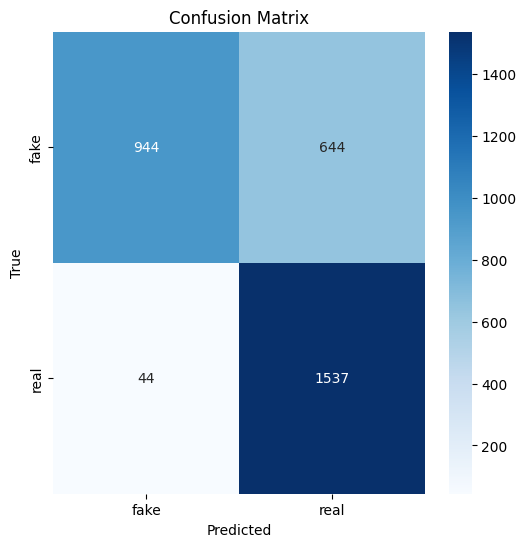

Confusion Matrix:
[[ 944  644]
 [  44 1537]]


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

#모델 평가: validation dataset에 대한 정확도 계산
val_loss, val_accuracy = model.evaluate(val_dataset)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

#예측 및 실제 레이블을 추출하여 Confusion Matrix 계산
y_true = []
y_pred = []

#validation dataset에 대해 예측 수행
for images, labels in val_dataset:
    predictions = model.predict(images,verbose=0)#로그 출력 생략verbose=0
    y_true.extend(labels.numpy())  #실제 레이블
    y_pred.extend(np.round(predictions))  #예측 레이블 (0 또는 1로 변환)

#Confusion Matrix 계산
cm = confusion_matrix(y_true, y_pred)

#Confusion Matrix 시각화
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CONFIGURATION["CLASS_NAMES"], yticklabels=CONFIGURATION["CLASS_NAMES"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

#Confusion Matrix 출력
print("Confusion Matrix:")
print(cm)

## 자체 데이터셋 준비

In [ ]:
# import os
# import unicodedata
# from PIL import Image

# # 이미지 경로 설정
# dataset_dir = "/content/drive/MyDrive/Generative_AI/generated_imageset/labeled_data"
# fake_dir = os.path.join(dataset_dir, "fake")

# # 파일명 정리 + 변환 함수
# def clean_and_convert_images(directory):
#     for filename in os.listdir(directory):
#         # 유니코드 정규화 (한글 깨짐 방지)
#         normalized_filename = unicodedata.normalize("NFC", filename)
#         new_filename = normalized_filename  # 기본 파일명 설정

#         # "의 사본" 삭제
#         if "의 사본" in new_filename:
#             new_filename = new_filename.replace("의 사본", "").strip()

#         # 중복 확장자 제거 (예: .webp.webp → .webp)
#         root, ext = os.path.splitext(new_filename)
#         if root.endswith(ext):
#             new_filename = root

#         old_path = os.path.join(directory, filename)
#         new_path = os.path.join(directory, new_filename)

#         # 파일명이 변경되었을 경우만 수정
#         if filename != new_filename:
#             os.rename(old_path, new_path)
#             print(f"Renamed: {filename} -> {new_filename}")
#             old_path = new_path  # 변경된 파일명을 기반으로 다시 설정

#         # 확장자가 .webp인 경우 .png로 변환
#         if new_filename.endswith(".webp"):
#             png_filename = new_filename.replace(".webp", ".png")
#             png_path = os.path.join(directory, png_filename)

#             with Image.open(old_path) as img:
#                 img.save(png_path, "PNG")  # PNG로 저장

#             os.remove(old_path)  # 원본 .webp 파일 삭제
#             print(f"Converted: {new_filename} -> {png_filename}")

# # fake 디렉토리에서만 실행
# clean_and_convert_images(fake_dir)

# print("📂 fake 디렉토리 파일 정리 및 변환 완료! ✅")


In [ ]:
# import os
# from PIL import Image

# # 이미지 경로 설정
# dataset_dir = "/content/drive/MyDrive/Generative_AI/generated_imageset/labeled_data"
# fake_dir = os.path.join(dataset_dir, "fake")
# real_dir = os.path.join(dataset_dir, "real")

# # 변환 함수
# def convert_webp_to_jpeg(directory):
#     for filename in os.listdir(directory):
#         if filename.endswith(".webp"):
#             webp_path = os.path.join(directory, filename)
#             jpeg_path = os.path.join(directory, filename.replace(".webp", ".jpeg"))

#             # 이미지 변환
#             with Image.open(webp_path) as img:
#                 img = img.convert("RGB")  # RGB 모드로 변환
#                 img.save(jpeg_path, "JPEG", quality=95)  # JPEG로 저장

#             # 원본 webp 삭제
#             os.remove(webp_path)
#             print(f"Converted and deleted: {webp_path}")

# # 각 디렉토리에서 변환 실행
# convert_webp_to_jpeg(fake_dir)
# convert_webp_to_jpeg(real_dir)

# print("변환 완료!")


In [11]:
import os

dataset_dir = "/content/drive/MyDrive/Generative_AI/generated_imageset/labeled_data"
fake_dir = os.path.join(dataset_dir, "fake")
real_dir = os.path.join(dataset_dir, "real")

fake_count = len(os.listdir(fake_dir)) if os.path.exists(fake_dir) else 0
real_count = len(os.listdir(real_dir)) if os.path.exists(real_dir) else 0

print(f"Fake: {fake_count}, Real: {real_count}")


Fake: 350, Real: 175


In [ ]:
# from PIL import Image
# import os

# MAX_PIXELS = 178956970  # 허용되는 최대 픽셀 크기 (Pillow 기본값)
# VALID_EXTENSIONS = {".jpg", ".jpeg", ".png"}
# def remove_invalid_images(directory):
#     for root, _, files in os.walk(directory):
#         for file in files:
#             file_path = os.path.join(root, file)
#             if not any(file.lower().endswith(ext) for ext in VALID_EXTENSIONS):
#                 continue  # 유효한 확장자가 아니면 건너뜀
#             try:
#                 img = Image.open(file_path)
#                 img.verify()  # 손상 여부 확인
#                 if img.size[0] * img.size[1] > MAX_PIXELS:
#                     print(f"Removing oversized image: {file_path}")
#                     os.remove(file_path)
#             except (IOError, SyntaxError, Image.DecompressionBombError):
#                 print(f"Removing invalid image: {file_path}")
#                 os.remove(file_path)

# remove_invalid_images(fake_dir)
# remove_invalid_images(real_dir)

## 자체 데이터셋에 대하여 테스트

In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import RandomOverSampler

# 데이터셋 경로
dataset_dir = "/content/drive/MyDrive/Generative_AI/generated_imageset/labeled_data"
fake_dir = "/content/drive/MyDrive/Generative_AI/generated_imageset/labeled_data/fake"
real_dir = "/content/drive/MyDrive/Generative_AI/generated_imageset/labeled_data/real"

In [17]:
fake_count = len(os.listdir(fake_dir)) if os.path.exists(fake_dir) else 0
real_count = len(os.listdir(real_dir)) if os.path.exists(real_dir) else 0

print(f"Fake: {fake_count}, Real: {real_count}")

Fake: 350, Real: 175


In [8]:
# 모델 로드
model_path = "/content/drive/MyDrive/Generative_AI/model/model_v1.h5"
model = load_model(model_path)

Found 520 images belonging to 2 classes.
{'fake': 0, 'real': 1}


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


130/130 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step
[[0.2898341 ]
 [0.28997877]
 [0.2898364 ]
 [0.2896912 ]
 [0.2897986 ]
 [0.28983447]
 [0.2894977 ]
 [0.28994936]
 [0.28962025]
 [0.28986543]
 [0.28986293]
 [0.2893438 ]
 [0.2898614 ]
 [0.28985497]
 [0.28997967]
 [0.28973827]
 [0.2899127 ]
 [0.28977844]
 [0.28981084]
 [0.28996125]
 [0.28995842]
 [0.28975314]
 [0.28992736]
 [0.289793  ]
 [0.28970534]
 [0.28993136]
 [0.28975627]
 [0.2898666 ]
 [0.28982592]
 [0.28972673]
 [0.28986135]
 [0.28991008]
 [0.28986588]
 [0.2899389 ]
 [0.28999144]
 [0.2900222 ]
 [0.28992802]
 [0.2900772 ]
 [0.28999   ]
 [0.29000655]
 [0.2898417 ]
 [0.28998125]
 [0.2901267 ]
 [0.29008046]
 [0.28992325]
 [0.29004627]
 [0.2898465 ]
 [0.28997377]
 [0.28995878]
 [0.28996792]
 [0.29004696]
 [0.28992677]
 [0.2898631 ]
 [0.28962004]
 [0.28980246]
 [0.2898887 ]
 [0.28985116]
 [0.2898881 ]
 [0.28973693]
 [0.29002577]
 [0.2899582 ]
 [0.28967878]
 [0.28997543]
 [0.28991362]
 [0.28985083]
 [0.2898509 ]
 [0.28983575]
 [0.28982592]
 [0.2

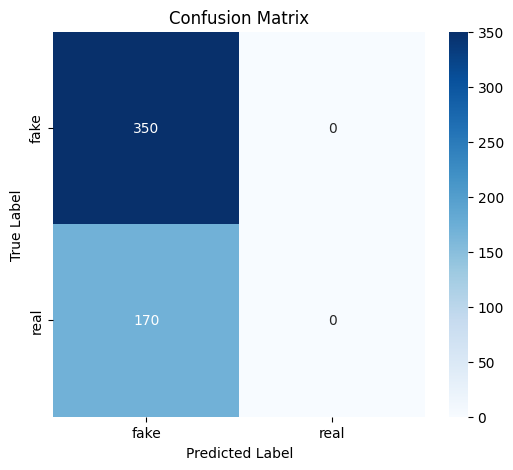


Classification Report:
              precision    recall  f1-score   support

        fake       0.67      1.00      0.80       350
        real       0.00      0.00      0.00       170

    accuracy                           0.67       520
   macro avg       0.34      0.50      0.40       520
weighted avg       0.45      0.67      0.54       520



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [21]:
# 이미지 크기 및 배치 사이즈 설정
img_size = (528, 528)  # EfficientNetB6의 입력 크기에 맞게 변경 가능
batch_size = 4

# 데이터 로더 설정 (test용)
datagen = ImageDataGenerator(rescale=1./255)


test_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="binary",  # 이진 분류 (fake vs real)
    shuffle= False
)

# 실제 라벨 가져오기
y_true = test_generator.classes  # 0: fake, 1: real
#print(y_true)
class_names = list(test_generator.class_indices.keys())
#print(class_names) #['fake', 'real']
#print(test_generator.class_indices)

# 예측 수행
y_pred_probs = model.predict(test_generator, steps=test_generator.samples // batch_size)  # 확률값 출력
print(y_pred_probs)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()  # 0.5 이상이면 1(real), 아니면 0(fake)

# 정확도 출력
accuracy = np.mean(y_pred == y_true)
print(f"Model Accuracy: {accuracy:.4f}")

# Confusion Matrix 생성
cm = confusion_matrix(y_true, y_pred)

# Confusion Matrix 시각화
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# 분류 보고서 출력
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


## 저장된 모델 로딩 -> 자체이미지 데이터셋에서 학습 후 이진분류

In [ ]:
import os
import shutil
import random
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, regularizers
import matplotlib.pyplot as plt

import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
train_dir = "/content/drive/MyDrive/Generative_AI/generated_imageset/train_new"
test_dir = "/content/drive/MyDrive/Generative_AI/generated_imageset/test_new"

In [ ]:
# 데이터 경로 (가정: images 폴더에 fake와 real 이미지들이 있음)
dataset_dir = "/content/drive/MyDrive/Generative_AI/generated_imageset"
fake_dir = os.path.join(dataset_dir, "fake")
real_dir = os.path.join(dataset_dir, "real")

# Train-Test Split을 위한 디렉토리 생성
train_dir = "/content/drive/MyDrive/Generative_AI/generated_imageset/train_new"
test_dir = "/content/drive/MyDrive/Generative_AI/generated_imageset/test_new"
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

train_fake_dir = os.path.join(train_dir, "fake")
test_fake_dir = os.path.join(test_dir, "fake")
train_real_dir = os.path.join(train_dir, "real")
test_real_dir = os.path.join(test_dir, "real")

os.makedirs(train_fake_dir, exist_ok=True)
os.makedirs(test_fake_dir, exist_ok=True)
os.makedirs(train_real_dir, exist_ok=True)
os.makedirs(test_real_dir, exist_ok=True)

# 이미지 파일 리스트 가져오기
fake_files = [os.path.join(fake_dir, f) for f in os.listdir(fake_dir) if os.path.isfile(os.path.join(fake_dir, f))]
real_files = [os.path.join(real_dir, f) for f in os.listdir(real_dir) if os.path.isfile(os.path.join(real_dir, f))]

# train-test split (80% train, 20% test)
fake_train, fake_test = train_test_split(fake_files, test_size=0.2, random_state=42)
real_train, real_test = train_test_split(real_files, test_size=0.2, random_state=42)

# 파일 이동
for file in fake_train:
    shutil.copy(file, train_fake_dir)
for file in fake_test:
    shutil.copy(file, test_fake_dir)
for file in real_train:
    shutil.copy(file, train_real_dir)
for file in real_test:
    shutil.copy(file, test_real_dir)

print("데이터셋 분할 완료!")


데이터셋 분할 완료!


In [ ]:
from PIL import Image
import os

MAX_PIXELS = 178956970  # 허용되는 최대 픽셀 크기 (Pillow 기본값)
VALID_EXTENSIONS = {".jpg", ".jpeg", ".png"}
def remove_invalid_images(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            if not any(file.lower().endswith(ext) for ext in VALID_EXTENSIONS):
                continue  # 유효한 확장자가 아니면 건너뜀
            try:
                img = Image.open(file_path)
                img.verify()  # 손상 여부 확인
                if img.size[0] * img.size[1] > MAX_PIXELS:
                    print(f"Removing oversized image: {file_path}")
                    os.remove(file_path)
            except (IOError, SyntaxError, Image.DecompressionBombError):
                print(f"Removing invalid image: {file_path}")
                os.remove(file_path)

remove_invalid_images(train_dir)
remove_invalid_images(test_dir)

In [ ]:
import os

train_fake_dir = os.path.join(train_dir, "fake")
train_real_dir = os.path.join(train_dir, "real")
test_fake_dir = os.path.join(test_dir, "fake")
test_real_dir = os.path.join(test_dir, "real")

train_fake_count = len(os.listdir(train_fake_dir)) if os.path.exists(train_fake_dir) else 0
train_real_count = len(os.listdir(train_real_dir)) if os.path.exists(train_real_dir) else 0
test_fake_count = len(os.listdir(test_fake_dir)) if os.path.exists(test_fake_dir) else 0
test_real_count = len(os.listdir(test_real_dir)) if os.path.exists(test_real_dir) else 0

print(train_fake_count,train_real_count,test_fake_count,test_real_count )
print(f"Fake: {train_fake_count + test_fake_count}, Real: {train_real_count + test_real_count}")


280 139 70 36
Fake: 350, Real: 175


In [ ]:
#저장된 EfficientNetB6 모델 로드
model_path = "/content/drive/MyDrive/Generative_AI/model/model_v1.h5"
model = load_model(model_path)

In [ ]:
#하이퍼파라미터 설정
CONFIGURATION = {
    "BATCH_SIZE": 4,
    "IM_SIZE": 528,  # EfficientNetB6의 입력 크기
    "LEARNING_RATE": 1e-4,
    "N_EPOCHS": 5,
    "DROPOUT_RATE": 0.2,
    "REGULARIZATION_RATE": 0.001,
    "N_DENSE_1": 1024,
    "CLASS_NAMES": ["fake", "real"]
}

n = 1
for layer in model.layers[:-n]:
    layer.trainable = False
for layer in model.layers[-n:]:
    layer.trainable = True

Found 415 images belonging to 2 classes.
Found 105 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 80s 552ms/step - accuracy: 0.3273 - loss: 0.8380 - val_accuracy: 0.3333 - val_loss: 0.7616
Epoch 2/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 35s 340ms/step - accuracy: 0.3572 - loss: 0.7447 - val_accuracy: 0.3333 - val_loss: 0.7101
Epoch 3/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 34s 329ms/step - accuracy: 0.4312 - loss: 0.7064 - val_accuracy: 0.6667 - val_loss: 0.6791
Epoch 4/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 36s 343ms/step - accuracy: 0.6269 - loss: 0.6686 - val_accuracy: 0.6667 - val_loss: 0.6614
Epoch 5/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 38s 361ms/step - accuracy: 0.6591 - loss: 0.6596 - val_accuracy: 0.6667 - val_loss: 0.6496


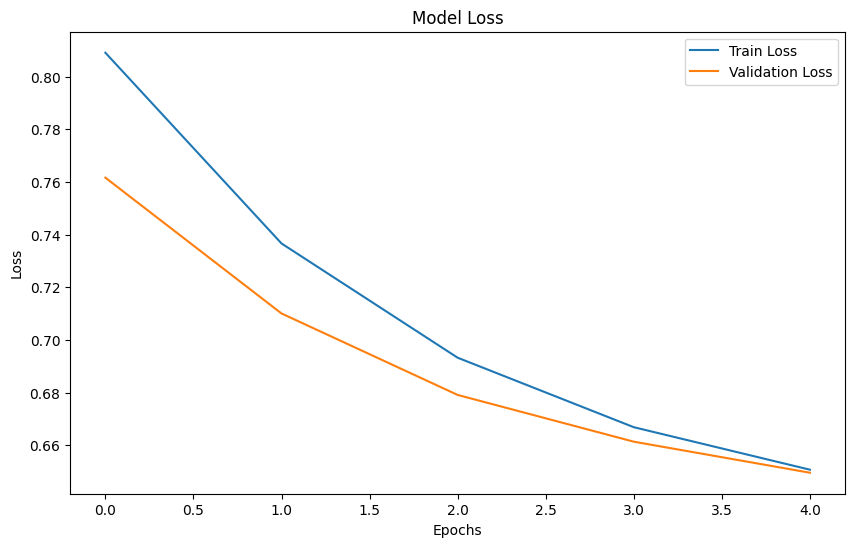

In [ ]:
#데이터 증강 및 로드
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_dataset = train_datagen.flow_from_directory(
    train_dir,
    target_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    batch_size=CONFIGURATION["BATCH_SIZE"],
    class_mode='binary'
)
val_dataset = val_datagen.flow_from_directory(
    test_dir,
    target_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    batch_size=CONFIGURATION["BATCH_SIZE"],
    class_mode='binary',
    shuffle=False,
    seed = 99
)

#모델 컴파일
model.compile(optimizer=Adam(learning_rate=CONFIGURATION["LEARNING_RATE"]),
              loss='binary_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

#모델 학습
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=CONFIGURATION["N_EPOCHS"],
    callbacks=[early_stopping],
    verbose=1
)

#학습 과정 시각화
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#모델 저장}|
model.save("/content/drive/MyDrive/Generative_AI/model/final_model_v1.keras")

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 모델 평가: Validation 데이터셋에 대한 정확도 계산
val_loss, val_accuracy = model.evaluate(val_dataset)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

# 예측 및 실제 레이블 추출
y_true = []
y_pred = []

# Validation 데이터셋에서 예측 수행
for images, labels in val_dataset:
    predictions = model.predict(images, verbose=0)  # 로그 출력 생략
    y_true.extend(labels)  # 실제 레이블
    y_pred.extend(np.round(predictions).flatten())  # 예측 레이블 (0 또는 1로 변환)

# Confusion Matrix 계산
cm = confusion_matrix(y_true, y_pred)

# Confusion Matrix 시각화
plt.figure(figsize=(6, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=CONFIGURATION["CLASS_NAMES"],
    yticklabels=CONFIGURATION["CLASS_NAMES"],
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Confusion Matrix 출력
print("Confusion Matrix:")
print(cm)


27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.9141 - loss: 0.6568
Validation Accuracy: 66.67%


KeyboardInterrupt: 